# Wave Combinator Session Data Exploration

This template is designed to help you explore per-session data from the Wave Combinator game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [ ]:
import os
print(os.getcwd())
!pip install --quiet --no-input -r ../../requirements.txt --log ./pip-installations.log

/workspaces/opengamedata-samples/PENGUINS/explore

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Standard Libraries
import math
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from OGDUtils.general.fileio import FileAPI, FileTypes
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [5]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change the settings below to configure which game/server location you want to use.

<!-- `ogd_server` : The file server that contains the actual data files -->
* `game_id` : The game whose data you want to access.
* `mode` : The kind of data you want to retrieve. Should be one of `FileTypes.PLAYER`, `FileTypes.POPULATION`, `FileTypes.SESSION`, `FileTypes.EVENTS` or `FileTypes.ALL_EVENTS`

In [6]:
game_id = 'PENGUINS'
mode    = FileTypes.SESSION

In [7]:
months_list = FileAPI.GetAvailableMonths(game_id)
print(f"The available months are:")
pprint(months_list, compact=True)

The available months are:
['10/2022', '11/2022', '12/2022', '1/2023', '2/2023', '3/2023', '4/2023',
 '5/2023', '6/2023', '7/2023', '8/2023', '9/2023']


In [8]:
month = 9
year = 2023

# download the file if it doesn't exist.
zip_file, dataset_name = FileAPI.DownloadZippedDataset(game_id, month, year, mode)
zip_name = zip_file.filename

Found the file PENGUINS_20230901_to_20230930_5cb9496_session-features.zip locally, nothing will be downloaded.


### Import Data Files to Jupyter

In [9]:
raw_data = pd.DataFrame()

# Open TSV from the zip file.
MAX_ROWS = 10000 # for the sake of not overwhelming RAM, only read first 10,000 rows of an events file
tsv_name = f"{zip_name[:zip_name.rfind('.')]}.tsv"
with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t', nrows=MAX_ROWS)
    #data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

# Data Overview

### Dataset README

Below, the readme file included with your dataset is displayed.
It includes information on the events and features for Wave Combinator.

In [10]:
# display(Markdown(data_readme.decode()))

### Data "Shape"

In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PlayerID                  10 non-null     float64
 1   SessionID                 1162 non-null   int64  
 2   ActivityCompleted         1162 non-null   object 
 3   ActivityDuration          1162 non-null   object 
 4   GazeCount                 1162 non-null   object 
 5   GazeDuration              1162 non-null   object 
 6   PickupRockCount           1162 non-null   int64  
 7   PlayerWaddleCount         1162 non-null   int64  
 8   RegionsEncountered        1162 non-null   object 
 9   SessionDuration           1162 non-null   object 
 10  region0_RegionDuration    1162 non-null   float64
 11  region1_RegionDuration    1162 non-null   float64
 12  region2_RegionDuration    1162 non-null   float64
 13  region3_RegionDuration    1162 non-null   float64
 14  region4_

In [12]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 1162 Rows, 32 Columns


### Column Names

Each Waves feature data file contains a large number of columns, each representing a single feature of gameplay.
Some features have one column per level, or one column per quiz question.
We call these **per-count** features.
Each **per-count** feature has a prefix indicating whether it was a *per-level* (prefix: `lvl`) or *per-quiz-question* (prefix: `QA`).  
Other features have only one column, based on play across all levels.
We call these **aggregate** or **session** features.

Below, the base feature names are listed.
**Per-count** features have the prefix shown in parentheses, and the number of columns with that base feature name shown to the right.
Note that **aggregate** features each have a "1" on the right, since each has just one column.

In [13]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [14]:
# percount_prefixes = ['lvl', 'QA']
column_groups = {
  pre : []
  #for pre in percount_prefixes + ['Aggregate']
  for pre in ['Aggregate']
}

for col in raw_data.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  found = False
  for pc_pre in ['Aggregate']:
    if prefix.startswith(pc_pre):
      column_groups[pc_pre].append(f"({pc_pre}) {pieces[1]}")
      found = True
  if not found:
    column_groups['Aggregate'].append(col)
col_set = Counter(sum(column_groups.values(), []))
print(f"There are {len(raw_data.columns)} columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

There are 32 columns in 32 groups:
Counter({'PlayerID': 1,
         'SessionID': 1,
         'ActivityCompleted': 1,
         'ActivityDuration': 1,
         'GazeCount': 1,
         'GazeDuration': 1,
         'PickupRockCount': 1,
         'PlayerWaddleCount': 1,
         'RegionsEncountered': 1,
         'SessionDuration': 1,
         'region0_RegionDuration': 1,
         'region1_RegionDuration': 1,
         'region2_RegionDuration': 1,
         'region3_RegionDuration': 1,
         'region4_RegionDuration': 1,
         'region5_RegionDuration': 1,
         'region6_RegionDuration': 1,
         'region7_RegionDuration': 1,
         'region8_RegionDuration': 1,
         'region9_RegionDuration': 1,
         'region10_RegionDuration': 1,
         'region0_WaddlePerRegion': 1,
         'region1_WaddlePerRegion': 1,
         'region2_WaddlePerRegion': 1,
         'region3_WaddlePerRegion': 1,
         'region4_WaddlePerRegion': 1,
         'region5_WaddlePerRegion': 1,
         'region

### Sample Rows

In [15]:
ROWS_TO_SHOW = 10

raw_data.head(ROWS_TO_SHOW)

,PlayerID,SessionID,ActivityCompleted,ActivityDuration,GazeCount,GazeDuration,PickupRockCount,PlayerWaddleCount,RegionsEncountered,SessionDuration,region0_RegionDuration,region1_RegionDuration,region2_RegionDuration,region3_RegionDuration,region4_RegionDuration,region5_RegionDuration,region6_RegionDuration,region7_RegionDuration,region8_RegionDuration,region9_RegionDuration,region10_RegionDuration,region0_WaddlePerRegion,region1_WaddlePerRegion,region2_WaddlePerRegion,region3_WaddlePerRegion,region4_WaddlePerRegion,region5_WaddlePerRegion,region6_WaddlePerRegion,region7_WaddlePerRegion,region8_WaddlePerRegion,region9_WaddlePerRegion,region10_WaddlePerRegion
0,NaN,23090113574728081,[],{},"{""BigRock00"": 3, ""Sea4"": 3, ""Sea5"": 1, ""River3...","{""Sea4"": ""0:00:00.367000"", ""Sea5"": ""-1 day, 23...",4,62,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:01:39.437000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,5,12,24,0,0,2,0,0,0,0
1,NaN,23090114005721708,[],"{""mating_dance"": ""0:00:00""}","{""BigRock00"": 7, ""Bridge2"": 8, ""BigRock01"": 6}","{""BigRock00"": ""0:03:48.275000"", ""Bridge2"": ""0:...",13,149,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:04:36.910000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,9,23,46,0,6,22,12,8,0,0
2,NaN,23090117350475222,[],{},"{""BigRock00"": 2, ""Bridge2"": 1}","{""BigRock00"": ""0:00:00.334000""}",0,0,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:03:38.486000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,23090117373034330,[],{},"{""Bridge"": 2, ""BigRock00"": 3}","{""BigRock00"": ""0:00:21.337000""}",0,0,[],0:01:01.988000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,23090117384676636,"[""mating_dance"", ""skuas""]","{""mating_dance"": ""0:01:05.327000"", ""skuas"": ""0...","{""Bridge2"": 6, ""BigRock00"": 6, ""Bridge"": 7}","{""BigRock00"": ""0:00:20.172000"", ""Bridge"": ""0:0...",20,245,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:09:39.521000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,5,25,22,26,0,16,8,39,0,48
5,NaN,23090117545363735,[],{},"{""BigRock00"": 6, ""Bridge2"": 1}","{""BigRock00"": ""0:00:18.983000""}",0,8,"[""Mirror""]",0:00:32.711000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,0,0,0,0,0,0,0,0
6,NaN,23090118202628681,[],{},{},{},0,0,[],0:00:05.979000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
7,NaN,23090118291423892,[],{},"{""Bridge"": 2, ""BigRock00"": 4}","{""BigRock00"": ""0:00:11.606000""}",0,0,[],0:00:36.642000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
8,NaN,23090119301353359,[],{},"{""BigRock00"": 1, ""Bridge2"": 2, ""Bridge"": 2, ""B...","{""BigRock00"": ""0:00:00"", ""Bridge2"": ""0:00:02.5...",3,104,"[""HillUp"", ""Entrance"", ""SnowballBowling"", ""Hil...",0:04:23.641000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,7,27,16,16,0,15,0,0,0,0
9,NaN,23090120474461420,[],{},"{""BigRock00"": 6, ""Bridge2"": 1, ""Bridge"": 1}","{""BigRock00"": ""0:00:34.628000"", ""Bridge"": ""0:0...",0,0,[],0:01:07.681000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0


### Summary of raw data

In [16]:
raw_data.describe(include='all')

,PlayerID,SessionID,ActivityCompleted,ActivityDuration,GazeCount,GazeDuration,PickupRockCount,PlayerWaddleCount,RegionsEncountered,SessionDuration,region0_RegionDuration,region1_RegionDuration,region2_RegionDuration,region3_RegionDuration,region4_RegionDuration,region5_RegionDuration,region6_RegionDuration,region7_RegionDuration,region8_RegionDuration,region9_RegionDuration,region10_RegionDuration,region0_WaddlePerRegion,region1_WaddlePerRegion,region2_WaddlePerRegion,region3_WaddlePerRegion,region4_WaddlePerRegion,region5_WaddlePerRegion,region6_WaddlePerRegion,region7_WaddlePerRegion,region8_WaddlePerRegion,region9_WaddlePerRegion,region10_WaddlePerRegion
count,10.000000,1.162000e+03,1162,1162,1162,1162,1162.000000,1162.000000,1162,1162,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.00000,1162.000000
unique,NaN,NaN,11,189,783,872,NaN,NaN,361,1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,[],{},{},"{""River3"": ""0:00:00""}",NaN,NaN,[],0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,972,833,248,158,NaN,NaN,419,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,476.000000,2.309216e+16,NaN,NaN,NaN,NaN,1.358864,72.197074,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.196213,3.009466,7.735800,11.608434,2.907917,0.939759,8.307229,4.225473,4.035284,2.05938,4.769363
std,268.366251,7.544457e+11,NaN,NaN,NaN,NaN,4.036158,115.078005,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.624887,4.178912,13.405165,22.964168,8.475589,3.178278,16.808423,8.804554,10.204775,5.73390,14.430808
min,111.000000,2.308312e+16,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,206.250000,2.309192e+16,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,576.000000,2.309251e+16,NaN,NaN,NaN,NaN,0.000000,25.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,647.000000,2.309262e+16,NaN,NaN,NaN,NaN,0.000000,98.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000,5.000000,12.000000,18.000000,1.000000,0.000000,15.000000,7.000000,1.000000,0.00000,0.000000


# Cleaning and Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [17]:
typed_data = raw_data.replace({'None':None})

In [18]:
# typed_data = typed_data.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
for col, dtype in zip(typed_data, typed_data.dtypes):
  if dtype == "string":
    try:
      typed_data[col] = pd.to_timedelta(typed_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

This dataframe contains data of the following types:
[dtype('float64') dtype('int64') dtype('O')]

Per feature, the data types are:
PlayerID                    float64
SessionID                     int64
ActivityCompleted            object
ActivityDuration             object
GazeCount                    object
GazeDuration                 object
PickupRockCount               int64
PlayerWaddleCount             int64
RegionsEncountered           object
SessionDuration              object
region0_RegionDuration      float64
region1_RegionDuration      float64
region2_RegionDuration      float64
region3_RegionDuration      float64
region4_RegionDuration      float64
region5_RegionDuration      float64
region6_RegionDuration      float64
region7_RegionDuration      float64
region8_RegionDuration      float64
region9_RegionDuration      float64
region10_RegionDuration     float64
region0_WaddlePerRegion       int64
region1_WaddlePerRegion       int64
region2_WaddlePerRegion       int64
regi

## Data Cleaning

#### Check for invalid Session IDs and null data.

In [19]:
bad_session_id = typed_data[typed_data.SessionID.isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

There are 0 rows containing invalid Session IDs.


,PlayerID,SessionID,ActivityCompleted,ActivityDuration,GazeCount,GazeDuration,PickupRockCount,PlayerWaddleCount,RegionsEncountered,SessionDuration,region0_RegionDuration,region1_RegionDuration,region2_RegionDuration,region3_RegionDuration,region4_RegionDuration,region5_RegionDuration,region6_RegionDuration,region7_RegionDuration,region8_RegionDuration,region9_RegionDuration,region10_RegionDuration,region0_WaddlePerRegion,region1_WaddlePerRegion,region2_WaddlePerRegion,region3_WaddlePerRegion,region4_WaddlePerRegion,region5_WaddlePerRegion,region6_WaddlePerRegion,region7_WaddlePerRegion,region8_WaddlePerRegion,region9_WaddlePerRegion,region10_WaddlePerRegion


In [20]:
null_data = typed_data.loc[:, typed_data.columns != 'SessionID'][typed_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.\nFirst five rows containing null data:\n")
null_data.head(5)

There are 1152 rows containing null data.
First five rows containing null data:



,PlayerID,ActivityCompleted,ActivityDuration,GazeCount,GazeDuration,PickupRockCount,PlayerWaddleCount,RegionsEncountered,SessionDuration,region0_RegionDuration,region1_RegionDuration,region2_RegionDuration,region3_RegionDuration,region4_RegionDuration,region5_RegionDuration,region6_RegionDuration,region7_RegionDuration,region8_RegionDuration,region9_RegionDuration,region10_RegionDuration,region0_WaddlePerRegion,region1_WaddlePerRegion,region2_WaddlePerRegion,region3_WaddlePerRegion,region4_WaddlePerRegion,region5_WaddlePerRegion,region6_WaddlePerRegion,region7_WaddlePerRegion,region8_WaddlePerRegion,region9_WaddlePerRegion,region10_WaddlePerRegion
0,NaN,[],{},"{""BigRock00"": 3, ""Sea4"": 3, ""Sea5"": 1, ""River3...","{""Sea4"": ""0:00:00.367000"", ""Sea5"": ""-1 day, 23...",4,62,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:01:39.437000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,5,12,24,0,0,2,0,0,0,0
1,NaN,[],"{""mating_dance"": ""0:00:00""}","{""BigRock00"": 7, ""Bridge2"": 8, ""BigRock01"": 6}","{""BigRock00"": ""0:03:48.275000"", ""Bridge2"": ""0:...",13,149,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:04:36.910000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,9,23,46,0,6,22,12,8,0,0
2,NaN,[],{},"{""BigRock00"": 2, ""Bridge2"": 1}","{""BigRock00"": ""0:00:00.334000""}",0,0,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:03:38.486000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,[],{},"{""Bridge"": 2, ""BigRock00"": 3}","{""BigRock00"": ""0:00:21.337000""}",0,0,[],0:01:01.988000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,"[""mating_dance"", ""skuas""]","{""mating_dance"": ""0:01:05.327000"", ""skuas"": ""0...","{""Bridge2"": 6, ""BigRock00"": 6, ""Bridge"": 7}","{""BigRock00"": ""0:00:20.172000"", ""Bridge"": ""0:0...",20,245,"[""Mirror"", ""HillUp"", ""Entrance"", ""SnowballBowl...",0:09:39.521000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,5,25,22,26,0,16,8,39,0,48


#### Remove sessions based on NaNs in specific columns

In [21]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["SessionID"]

df_session = typed_data.dropna(subset=drop_nas)
df_session.reset_index(inplace=True)
print(f"After removing rows with NA values, there are {df_session.shape[0]} rows remaining")

After removing rows with NA values, there are 1162 rows remaining


## Finding outliers

Execute the following chunk only when the features are timedelta

In [22]:
# for col in target_columns:
#   df_Interested[col] = df_Interested[col].dt.total_seconds()


In [23]:
# bigoutliers = np.where(df_Interested[target_columns].ge(4000))
# bigoutliers

In [24]:
# for i, j in zip(bigoutliers[0], bigoutliers[1]):
#   df_Interested[target_columns].iat[i, j] = 0

## Data Transforms

# Feature Summaries

This section shows some basic statistical summaries of the feature columns listed previously.
These summaries are across all sessions in the data file.

#### Summary of Aggregate (whole-session) features

In [25]:
df_session[column_groups['Aggregate']].describe(include = 'all')

,PlayerID,SessionID,ActivityCompleted,ActivityDuration,GazeCount,GazeDuration,PickupRockCount,PlayerWaddleCount,RegionsEncountered,SessionDuration,region0_RegionDuration,region1_RegionDuration,region2_RegionDuration,region3_RegionDuration,region4_RegionDuration,region5_RegionDuration,region6_RegionDuration,region7_RegionDuration,region8_RegionDuration,region9_RegionDuration,region10_RegionDuration,region0_WaddlePerRegion,region1_WaddlePerRegion,region2_WaddlePerRegion,region3_WaddlePerRegion,region4_WaddlePerRegion,region5_WaddlePerRegion,region6_WaddlePerRegion,region7_WaddlePerRegion,region8_WaddlePerRegion,region9_WaddlePerRegion,region10_WaddlePerRegion
count,10.000000,1.162000e+03,1162,1162,1162,1162,1162.000000,1162.000000,1162,1162,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.0,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.00000,1162.000000
unique,NaN,NaN,11,189,783,872,NaN,NaN,361,1150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,[],{},{},"{""River3"": ""0:00:00""}",NaN,NaN,[],0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,972,833,248,158,NaN,NaN,419,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,476.000000,2.309216e+16,NaN,NaN,NaN,NaN,1.358864,72.197074,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.196213,3.009466,7.735800,11.608434,2.907917,0.939759,8.307229,4.225473,4.035284,2.05938,4.769363
std,268.366251,7.544457e+11,NaN,NaN,NaN,NaN,4.036158,115.078005,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.624887,4.178912,13.405165,22.964168,8.475589,3.178278,16.808423,8.804554,10.204775,5.73390,14.430808
min,111.000000,2.308312e+16,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,206.250000,2.309192e+16,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,576.000000,2.309251e+16,NaN,NaN,NaN,NaN,0.000000,25.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,647.000000,2.309262e+16,NaN,NaN,NaN,NaN,0.000000,98.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000,5.000000,12.000000,18.000000,1.000000,0.000000,15.000000,7.000000,1.000000,0.00000,0.000000


#### Summary of a Per-Count feature

In [26]:
# Choose which per-count feature you'd like to see summarized
per_count = "WaddlePerRegion"

cols = [col for col in raw_data.columns if col.endswith(per_count)]
raw_data[cols].describe(include='all')

,region0_WaddlePerRegion,region1_WaddlePerRegion,region2_WaddlePerRegion,region3_WaddlePerRegion,region4_WaddlePerRegion,region5_WaddlePerRegion,region6_WaddlePerRegion,region7_WaddlePerRegion,region8_WaddlePerRegion,region9_WaddlePerRegion,region10_WaddlePerRegion
count,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.00000,1162.000000
mean,6.196213,3.009466,7.735800,11.608434,2.907917,0.939759,8.307229,4.225473,4.035284,2.05938,4.769363
std,7.624887,4.178912,13.405165,22.964168,8.475589,3.178278,16.808423,8.804554,10.204775,5.73390,14.430808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,10.000000,5.000000,12.000000,18.000000,1.000000,0.000000,15.000000,7.000000,1.000000,0.00000,0.000000
max,67.000000,60.000000,228.000000,347.000000,150.000000,40.000000,256.000000,95.000000,110.000000,60.00000,131.000000


# Visualizations

### Simple feature value distribution visualization

In [27]:
df_session['SessionDuration'] = pd.to_timedelta(df_session['SessionDuration'])
feature_to_visualize = "SessionDuration"

# Use pd.Timedelta objects for minimum and maximum values
minimum_value = pd.Timedelta.min
maximum_value = pd.Timedelta(seconds=604800)

range_filter = (df_session[feature_to_visualize] > minimum_value) & (df_session[feature_to_visualize] < maximum_value)
plot_data = df_session[feature_to_visualize][range_filter]

# Use total_seconds to convert timedelta to a float for describe()
plot_data_seconds = plot_data.dt.total_seconds()
print(pd.Series(plot_data_seconds).describe())

count      1162.000000
mean        919.058342
std       11839.469656
min           0.000000
25%          30.859250
50%          63.243000
75%         157.714000
max      346731.585000
Name: SessionDuration, dtype: float64


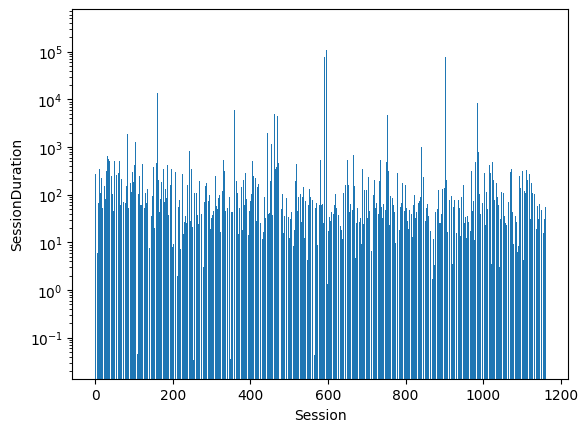

In [28]:
# Plot bar chart
# some numbers are really weird 
f, ax = plt.subplots()
ax.bar(range(len(plot_data_seconds)), plot_data_seconds)
# Set logarithmic scale for the y-axis
ax.set_yscale('log')  
ax.set_xlabel('Session')
ax.set_ylabel(feature_to_visualize)
plt.show()


In [ ]:
durations_df['TotalDuration'].dt.total_seconds().describe()

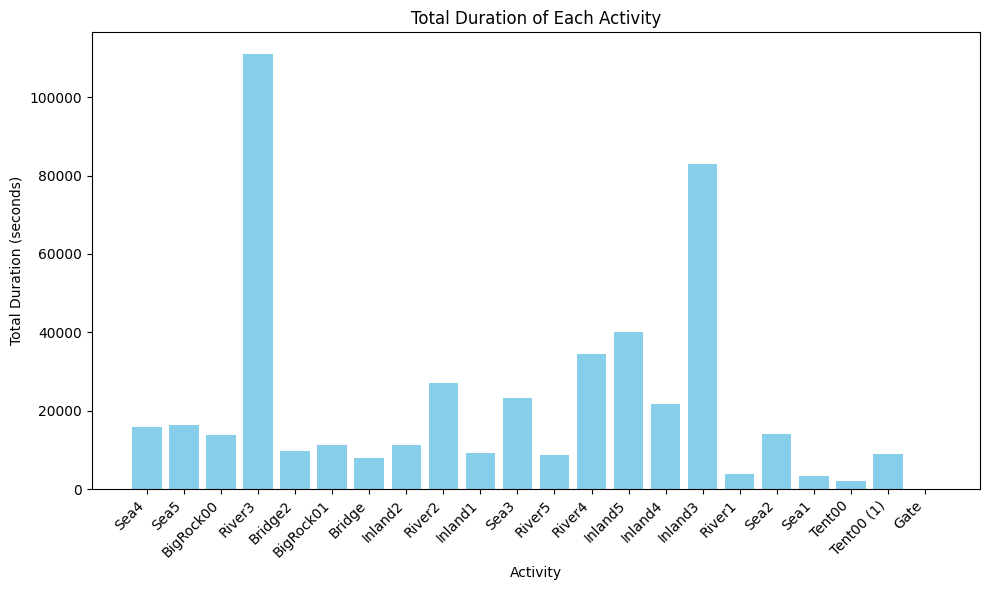

In [ ]:
df_session['GazeDuration'] = df_session['GazeDuration'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def aggregate_durations(durations_dict_list):
    aggregated_durations = {}
    for durations_dict in durations_dict_list:
        for activity, duration in durations_dict.items():
            duration_td = pd.to_timedelta(duration)
            if activity in aggregated_durations:
                aggregated_durations[activity] += duration_td
            else:
                aggregated_durations[activity] = duration_td
    return aggregated_durations

all_durations_dict_list = df_session['GazeDuration'].tolist()
aggregated_durations = aggregate_durations(all_durations_dict_list)

durations_df = pd.DataFrame(list(aggregated_durations.items()), columns=['Activity', 'TotalDuration'])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(durations_df['Activity'], durations_df['TotalDuration'].dt.total_seconds(), color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Total Duration (seconds)')
plt.title('Total Duration of Each Activity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#mirror didn't show up 

### Simple feature comparison scatterplot

In [28]:
for region_number in range(10):
    x_axis_feature = f"region{region_number}_WaddlePerRegion"
    minimum_x_value = -math.inf
    maximum_x_value = math.inf
    y_axis_feature = f"region{region_number + 1}_WaddlePerRegion"
    minimum_y_value = -math.inf
    maximum_y_value = math.inf

    range_filter = (df_session[x_axis_feature] > minimum_x_value) & (df_session[x_axis_feature] < maximum_x_value) \
                 & (df_session[y_axis_feature] > minimum_y_value) & (df_session[y_axis_feature] < maximum_y_value)
    scatter_data = df_session[[x_axis_feature, y_axis_feature]][range_filter]
    
    # Print description for the scatter_data for this region
    print(f"Region {region_number} vs Region {region_number + 1} Scatter Plot Statistics:")
    print(scatter_data.describe())

Region 0 vs Region 1 Scatter Plot Statistics:
       region0_WaddlePerRegion  region1_WaddlePerRegion
count              1162.000000              1162.000000
mean                  6.196213                 3.009466
std                   7.624887                 4.178912
min                   0.000000                 0.000000
25%                   0.000000                 0.000000
50%                   7.000000                 2.000000
75%                  10.000000                 5.000000
max                  67.000000                60.000000
Region 1 vs Region 2 Scatter Plot Statistics:
       region1_WaddlePerRegion  region2_WaddlePerRegion
count              1162.000000              1162.000000
mean                  3.009466                 7.735800
std                   4.178912                13.405165
min                   0.000000                 0.000000
25%                   0.000000                 0.000000
50%                   2.000000                 0.000000
75%         

/tmp/ipykernel_3200/1035139551.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', 10)


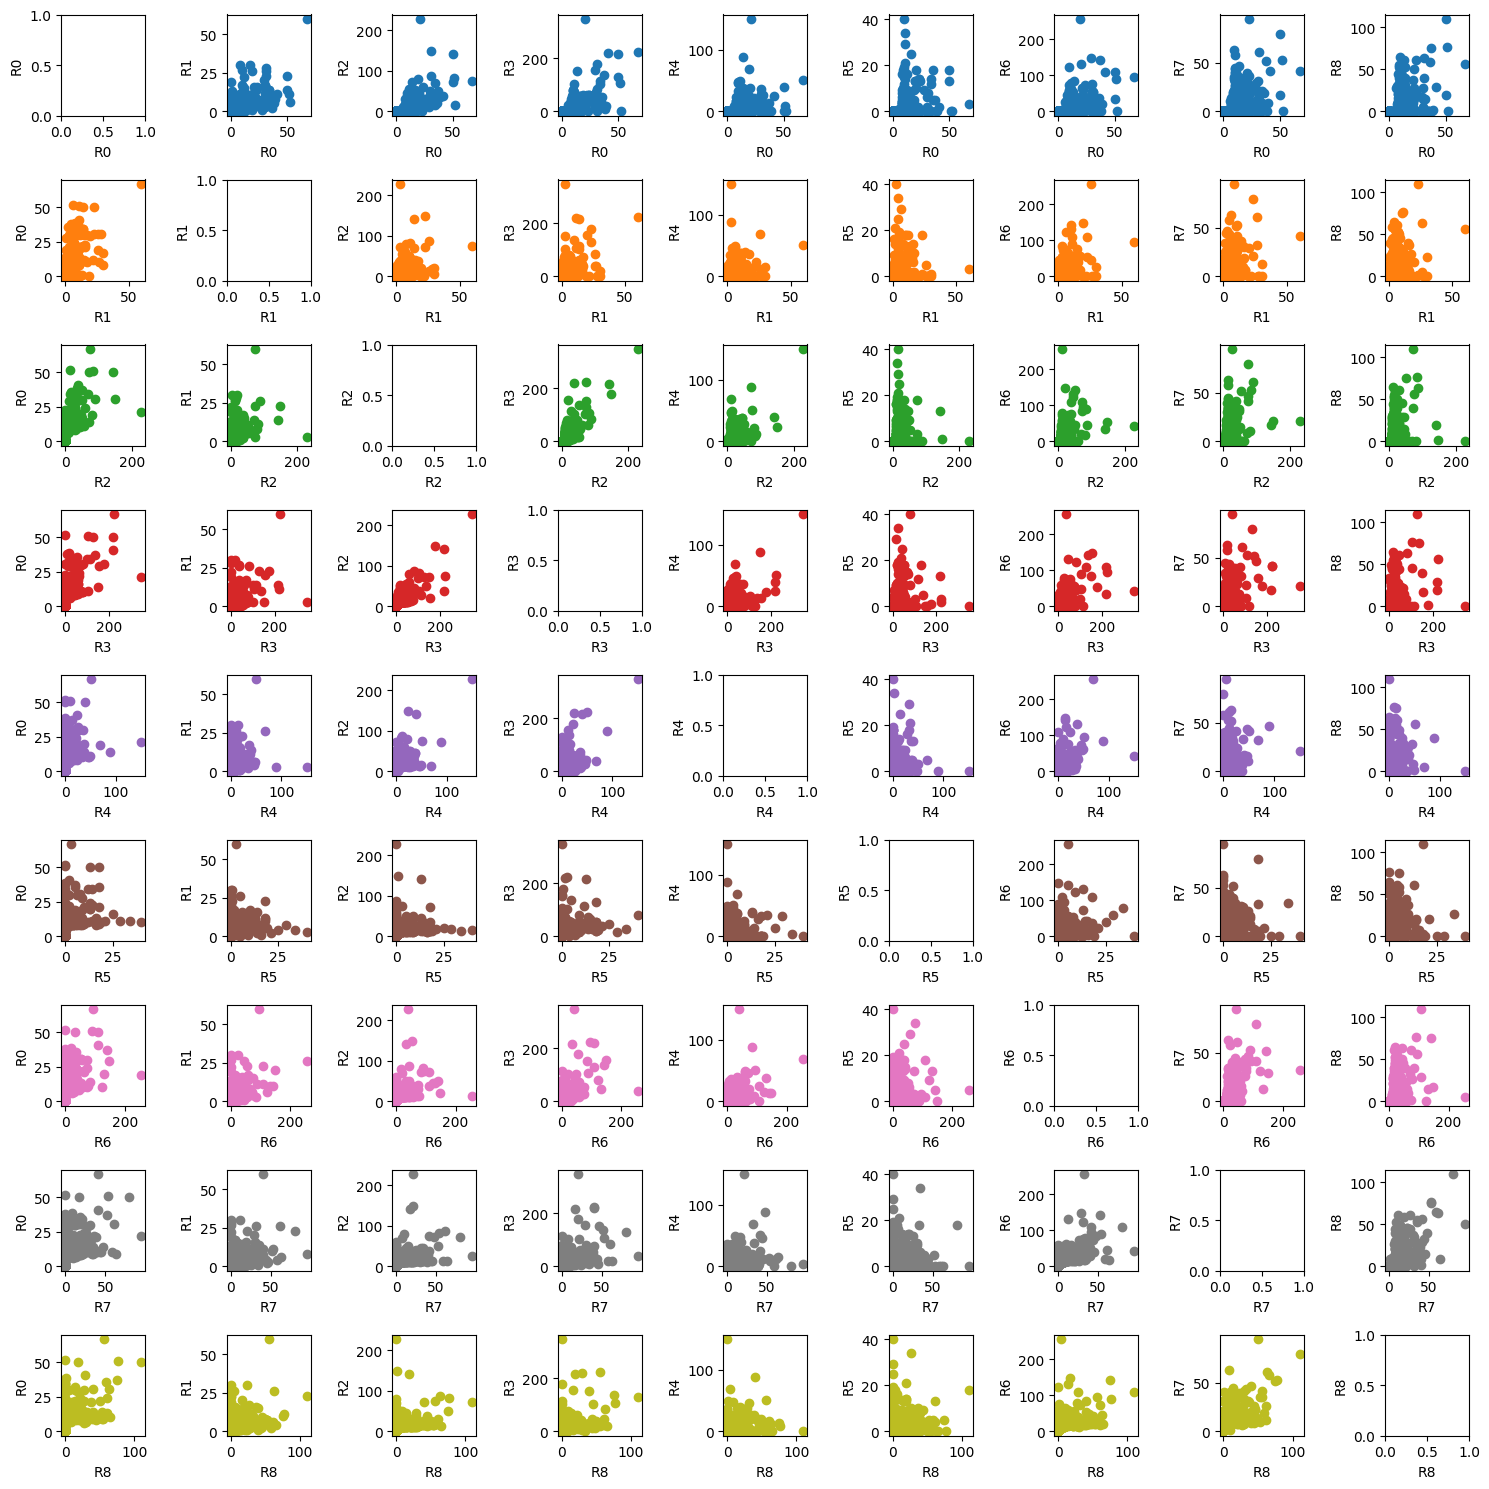

In [29]:
colormap = plt.cm.get_cmap('tab10', 10)

fig, axs = plt.subplots(nrows=9, ncols=9, figsize=(15, 15))

for i in range(9):
    for j in range(9):
        ax = axs[i, j]
        
        if i != j:
            x_axis_feature = f"region{i}_WaddlePerRegion"
            y_axis_feature = f"region{j}_WaddlePerRegion"

            scatter_data = df_session[[x_axis_feature, y_axis_feature]]

            # Get a unique color for this region from the colormap
            color = colormap(i)
            
            # Create a scatter plot for this region with a unique color
            ax.scatter(scatter_data[x_axis_feature], scatter_data[y_axis_feature], color=color)
        
        ax.set_xlabel(f"R{i}")
        ax.set_ylabel(f"R{j}")

plt.tight_layout()
plt.show()

# bar chart of overall number of waddles & avg num of waddle for waddle> 0

## How Many Players?

In [30]:
# Not just "how many played at all", but SessionDuration > 1 minute & entered at least one region

# Filter sessions with duration > 1 minute
filtered_sessions = df_session[pd.to_timedelta(df_session['SessionDuration']) > pd.Timedelta(minutes=1)]
# Filter sessions where at least one region was encountered
filtered_sessions = filtered_sessions[filtered_sessions['RegionsEncountered'].notnull() & (filtered_sessions['RegionsEncountered'] != '')]
# Get level completion columns
level_completion_columns = filtered_sessions[filtered_sessions.columns[filtered_sessions.columns.str.endswith("ActivityCompleted")]]

# Sum level completions per player
per_player_levels_completed = level_completion_columns.sum(axis=1)

per_player_levels_completed

0                              []
1                              []
2                              []
3                              []
4       ["mating_dance", "skuas"]
                  ...            
1149                           []
1152                           []
1153                           []
1159    ["mating_dance", "skuas"]
1161                           []
Length: 606, dtype: object

In [31]:
completed_mask = per_player_levels_completed.apply(len) > 0
filtered_per_player_levels_completed = per_player_levels_completed[completed_mask]

print(f"There were {df_session.shape[0]} sessions in the dataset (after cleaning).\nOf those, {filtered_per_player_levels_completed.shape[0]} sessions completed at least one activity.")


There were 1162 sessions in the dataset (after cleaning).
Of those, 606 sessions completed at least one activity.


## How Far Did They Get?

Counter({'[]': 972, '["mating_dance"]': 100, '["mating_dance", "skuas"]': 47, '["skuas"]': 23, '["skuas", "skuas"]': 10, '["mating_dance", "skuas", "skuas"]': 5, '["mating_dance", "mating_dance"]': 1, '["mating_dance", "mating_dance", "mating_dance", "mating_dance", "skuas"]': 1, '["mating_dance", "skuas", "skuas", "mating_dance", "skuas", "skuas", "mating_dance", "skuas", "skuas"]': 1, '["mating_dance", "skuas", "mating_dance", "skuas", "mating_dance", "skuas", "mating_dance", "skuas", "mating_dance", "skuas", "mating_dance", "skuas"]': 1, '["skuas", "mating_dance", "skuas"]': 1})


/tmp/ipykernel_3200/1334992963.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


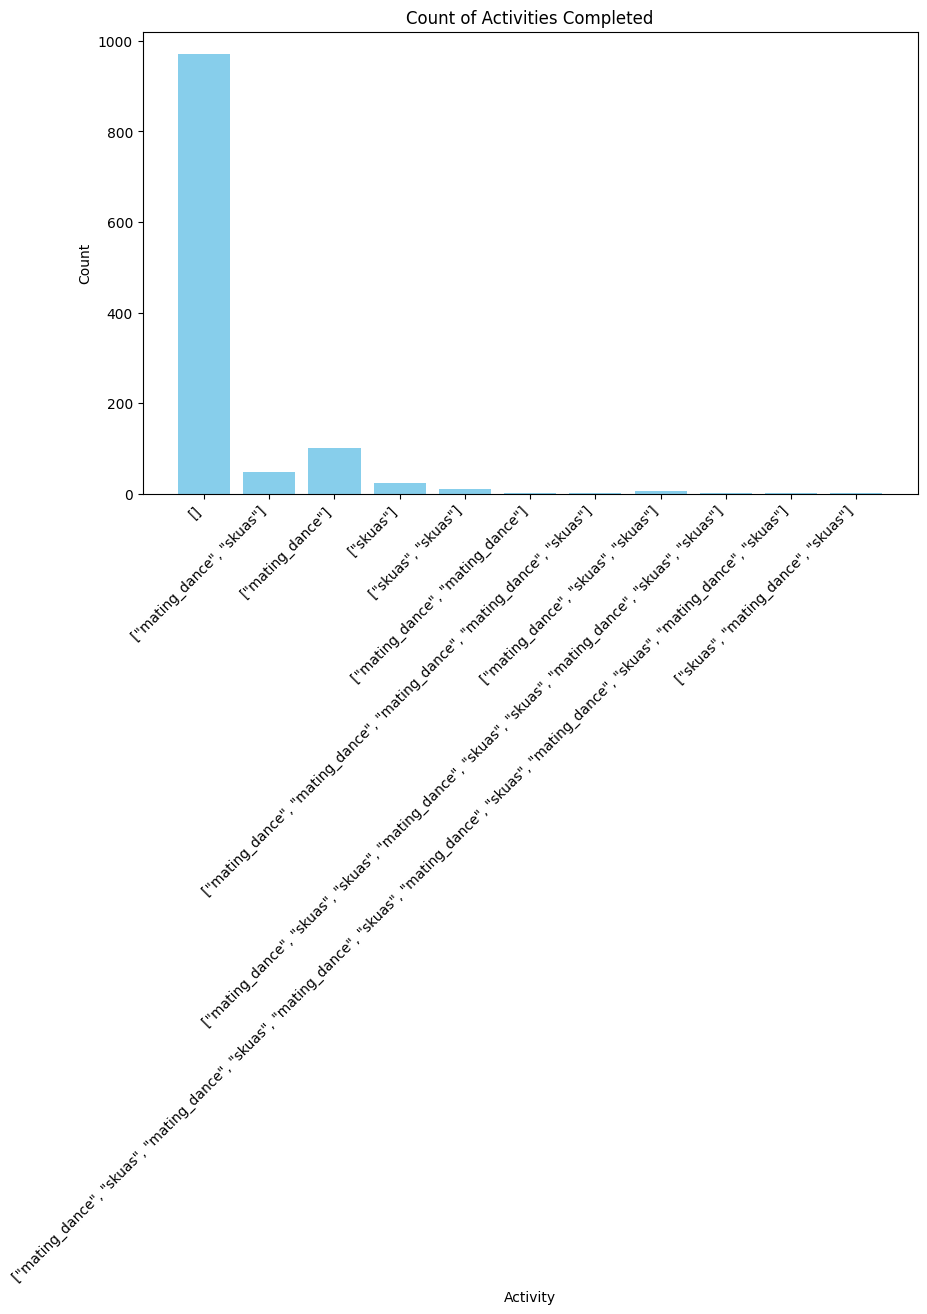

In [32]:
# Step 1: Use the "ActivityCompleted" column directly
all_activities = df_session['ActivityCompleted'].explode().tolist()

# Step 2: Count the occurrences of each activity
activity_counts = Counter(all_activities)
print(activity_counts)
# Step 3: Create a bar plot
plt.figure(figsize=(10, 6))
activities, counts = zip(*activity_counts.items())
plt.bar(activities, counts, color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Count of Activities Completed')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Counter({'mating_dance': 168, 'skuas': 115})


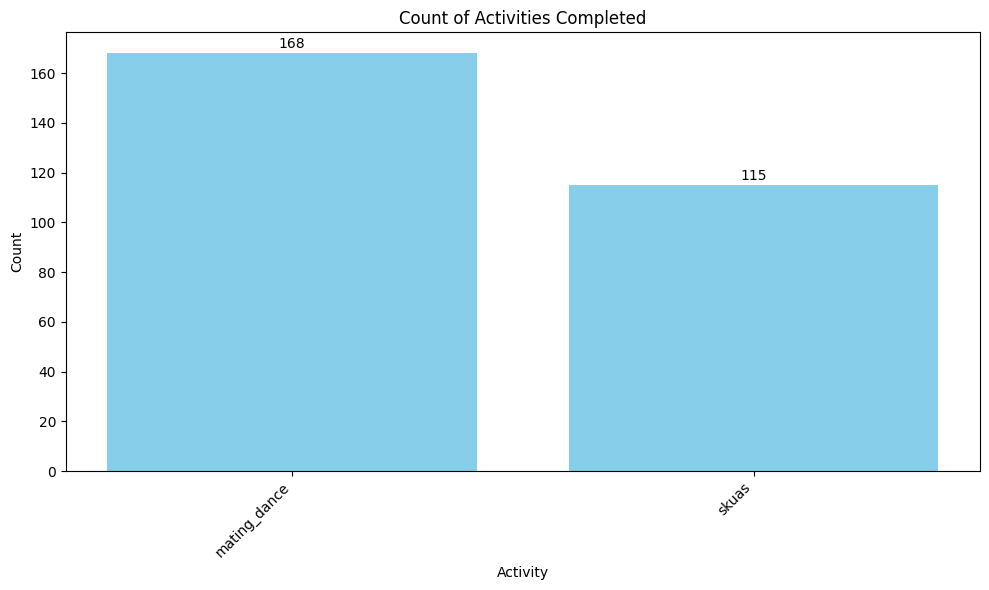

In [33]:
import matplotlib.pyplot as plt
import ast
from collections import Counter

# Step 1: Convert string representations of lists back into lists
df_session['ActivityCompleted'] = df_session['ActivityCompleted'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Convert lists in 'ActivityCompleted' column into a single big list
all_activities = [activity for sublist in df_session['ActivityCompleted'].dropna() for activity in sublist]

# Step 3: Count the occurrences of each activity
activity_counts = Counter(all_activities)
print(activity_counts)

# Step 4: Create a bar plot
plt.figure(figsize=(10, 6))
activities, counts = zip(*activity_counts.items())
bars = plt.bar(activities, counts, color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Count of Activities Completed')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of the bars
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, count, ha='center', va='bottom')

plt.tight_layout()
plt.show()

Counter({'SnowballBowling': 846, 'Mirror': 841, 'HillUp': 755, 'Entrance': 748, 'Bridge': 648, 'MatingDPath': 611, 'MatingD': 471, 'HillDown': 432, 'ProtectNest': 292, 'ProtectNestPath': 274, 'Chimes': 203})


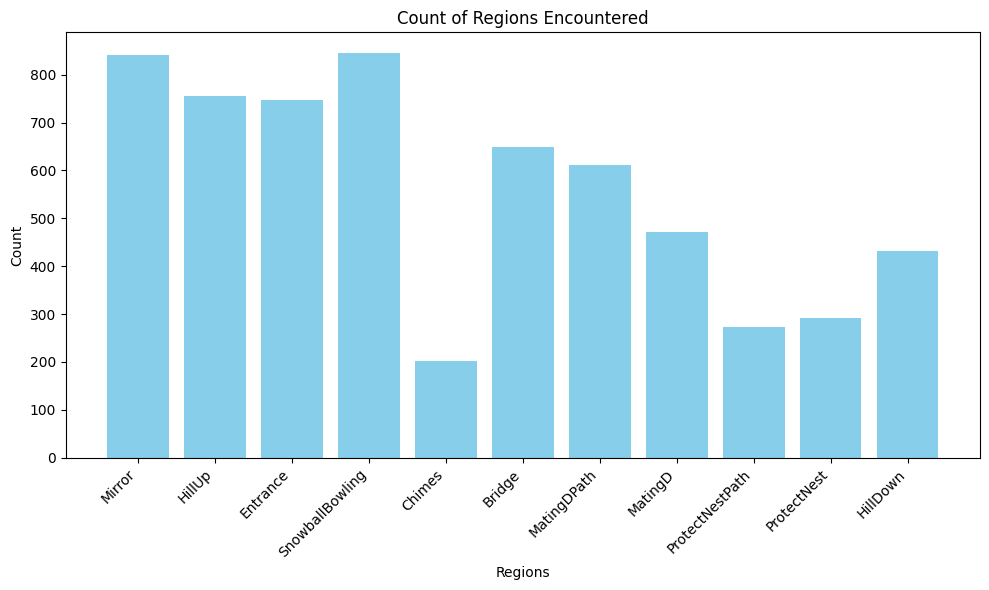

In [34]:
import ast
# Step 1: Convert string representations of lists back into lists
df_session['RegionsEncountered'] = df_session['RegionsEncountered'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Use the "RegionsEncountered" column directly
all_activities = [activity for sublist in df_session['RegionsEncountered'].dropna() for activity in sublist]

# Step 2: Count the occurrences of each activity
activity_counts = Counter(all_activities)
print(activity_counts)

# Step 3: Create a bar plot
plt.figure(figsize=(10, 6))
activities, counts = zip(*activity_counts.items())
plt.bar(activities, counts, color='skyblue')
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Count of Regions Encountered')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

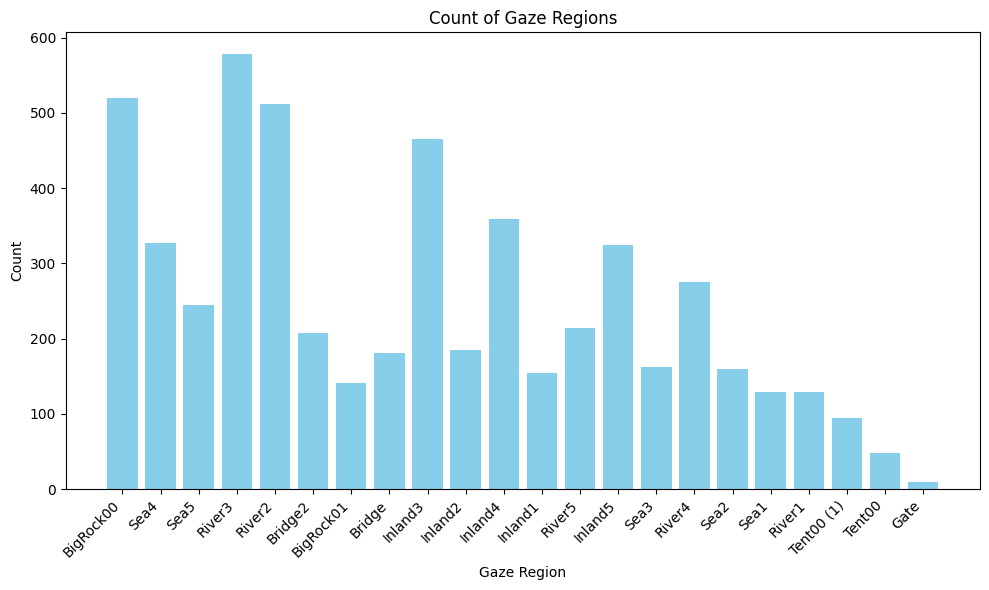

In [36]:
# Step 1: Convert string representations back into their original formats
df_session['GazeCount'] = df_session['GazeCount'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 2: Flatten the dictionaries in the 'GazeCount' column and count the occurrences of each gaze region
all_gaze_counts = [item for sublist in df_session['GazeCount'].dropna() for item in sublist.items()]
gaze_regions, counts = zip(*all_gaze_counts)
gaze_counts = Counter(gaze_regions)

# Step 3: Create a bar plot
plt.figure(figsize=(10, 6))
regions, counts = zip(*gaze_counts.items())
plt.bar(regions, counts, color='skyblue')
plt.xlabel('Gaze Region')
plt.ylabel('Count')
plt.title('Count of Gaze Regions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of Players Completing Each Level')

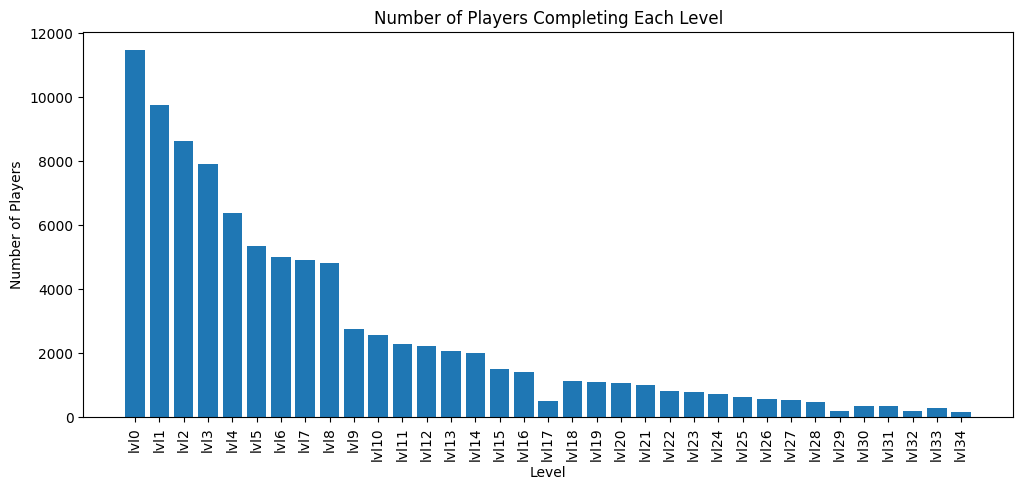

In [31]:
per_level_completions = level_completion_columns.sum(axis=0)
f,ax = plt.subplots(figsize=(12, 5))
ax.bar([col.split('_')[0] for col in level_completion_columns.columns], per_level_completions)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Number of Players")
ax.set_title("Number of Players Completing Each Level")

## How Long Did They Play?

In [33]:
minimum_value = 0
maximum_value = 1000

range_filter = (df_session[time_feature] > minimum_value) & (df_session[time_feature] < maximum_value)
time_data = df_session[time_feature][range_filter]
time_data.describe()

count    11380.000000
mean        50.337773
std         70.517608
min          0.736000
25%         14.934000
50%         32.515750
75%         59.652925
max        963.014556
Name: AverageLevelTime, dtype: float64

Text(0.5, 1.0, 'Histogram for Average Time Per Level')

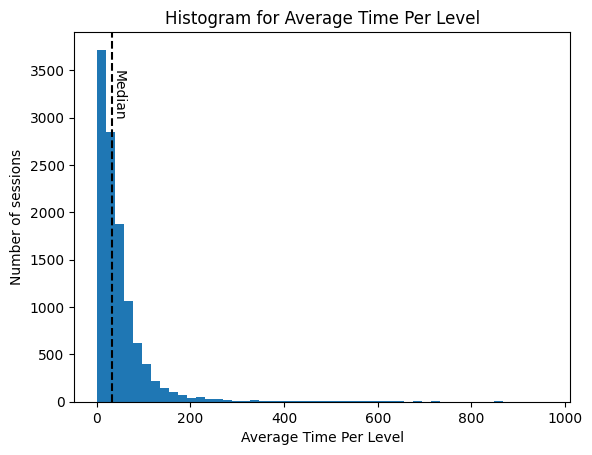

In [34]:
f, ax = plt.subplots()
ax.hist(time_data, bins=50)
ax.axvline(x=time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=time_data.median() + 0.25, y=3000, s="Median", rotation=-90)
ax.set_xlabel("Average Time Per Level")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Average Time Per Level")

In [35]:
level_time_columns = df_session[df_session.columns[df_session.columns.str.endswith("TotalLevelTime")]]

per_player_total_time = level_time_columns.sum(axis=1)
per_player_total_time.describe()

count     12099.000000
mean       1183.262604
std        9543.908709
min        -249.544000
25%          42.459500
50%         219.347000
75%         656.041500
max      489750.058000
dtype: float64

In [36]:
minimum_value = 0
maximum_value = 5000

range_filter = (per_player_total_time > minimum_value) & (per_player_total_time < maximum_value)
total_time_data = per_player_total_time[range_filter]
total_time_data.describe()

count    11278.000000
mean       476.923657
std        648.393231
min          1.289000
25%         54.458000
50%        237.053500
75%        652.023750
max       4982.467000
dtype: float64

Text(0.5, 1.0, 'Histogram for Total Play Times')

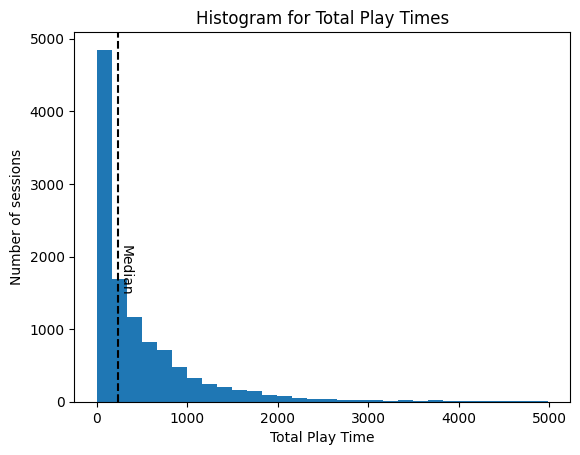

In [37]:
f, ax = plt.subplots()
ax.hist(total_time_data, bins=30)
ax.axvline(x=total_time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=total_time_data.median() + 0.25, y=1500, s="Median", rotation=-90)
ax.set_xlabel("Total Play Time")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Total Play Times")

Text(0.5, 1.0, 'Total Time Played in each Level')

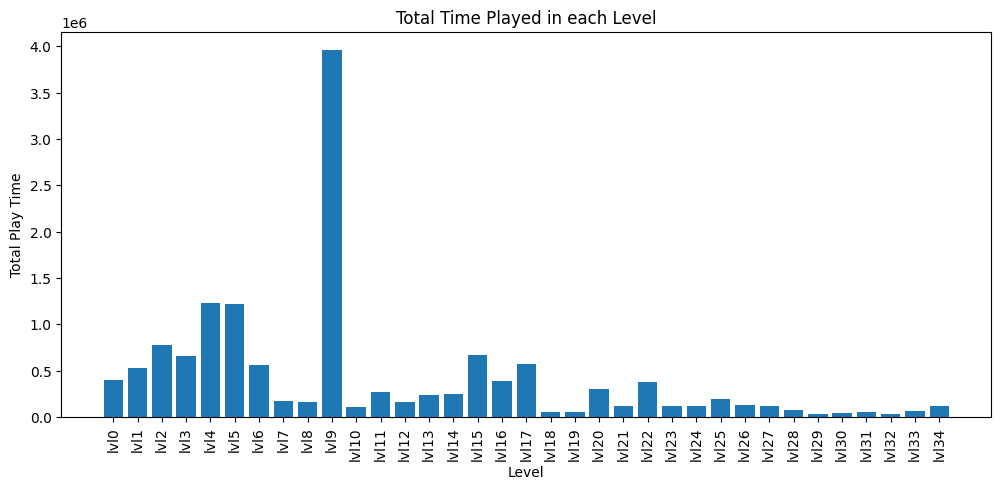

In [38]:
per_level_total_time = level_time_columns.sum(axis=0)

f,ax = plt.subplots(figsize=(12, 5))
ax.bar([col.split('_')[0] for col in level_completion_columns.columns], per_level_total_time)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Total Play Time")
ax.set_title("Total Time Played in each Level")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [39]:
#@markdown Choose your own metric for test here
response_variable = "AverageFails"
min_response_val = 0
max_response_val = 20
independent_variable = "AverageMoveTypeChanges" #@param {type:'string'}
min_independent_val = 0
max_independent_val = 6
# Dividing_value = "20" #@param {type: 'string'}
comparison_data = df_session[[response_variable, independent_variable]]
comparison_data = comparison_data[(df_session[response_variable] >= min_response_val) & (df_session[response_variable] <= max_response_val)
                                & (df_session[independent_variable] >= min_independent_val) & (df_session[independent_variable] <= max_independent_val)]
response_data = np.log(comparison_data[response_variable])
independent_data = comparison_data[independent_variable]

Text(0.5, 1.0, 'Histogram for AverageMoveTypeChanges')

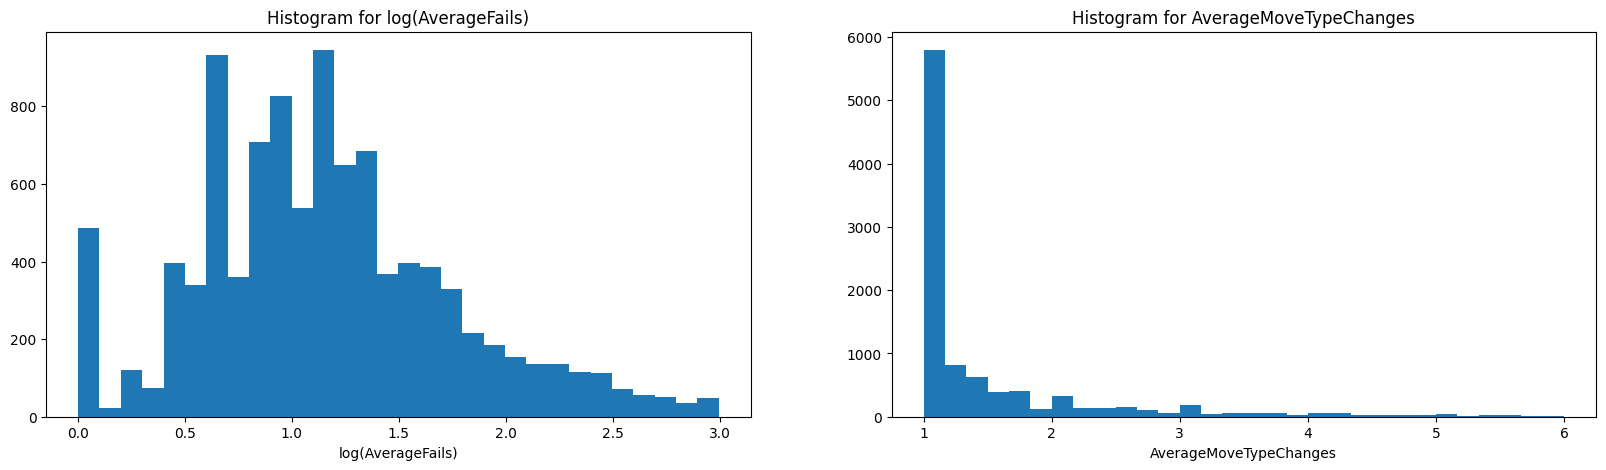

In [40]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].hist(response_data, bins=30)
ax[0].set_xlabel(f"log({response_variable})")
ax[0].set_title(f"Histogram for log({response_variable})")
ax[1].hist(independent_data, bins=30)
ax[1].set_xlabel(independent_variable)
ax[1].set_title(f"Histogram for {independent_variable}")

In [41]:
group_data = independent_data.ge(independent_data.mean())
group_data.describe()
# independent_data.describe()

count      9874
unique        2
top       False
freq       7225
Name: AverageMoveTypeChanges, dtype: object

In [42]:
pairwise = pairwise_tukeyhsd(endog=response_data, groups=group_data, alpha=0.05)
print(pairwise)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 False   True   0.0109 0.4191 -0.0156 0.0374  False
---------------------------------------------------
